In [1]:
# Initial imports and notebook setup, click arrow to show
import sys 
import os
import numpy as np

from HARK.ConsumptionSaving.ConsPrefShockModel import *

import matplotlib.pyplot as plt

This module defines consumption-saving models in which agents have CRRA utility over a unitary consumption good, geometric discounting, who face idiosyncratic shocks to income and to their utility or preferences. That is, this module contains models that extend $\texttt{ConsIndShockModel}$ with preference shocks.

$\texttt{ConsPrefShockModel}$ currently solves two types of models:
1. An extension of $\texttt{ConsIndShock}$, but with an iid lognormal multiplicative shock each period.
2. A combination of (1) and $\texttt{ConsKinkedR}$, demonstrating how to construct a new model
   by inheriting from multiple classes.

### Multiplicative Shocks to Utility

In this model, an agent is very similar to the one in the "idiosyncratic shocks" model, except that in $\texttt{ConsPrefShockModel}$ an agent receives an iid multiplicative shock to his/her utility at the beginning of each period, before making the consumption decision. 

The agent's problem can be written in (normalized) Bellman form as:

\begin{eqnarray*}
v_t(m_t,\eta_t) &=& \max_{c_t} u(\eta_t.c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E} [(\Gamma_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}, \eta_{t+1}) ], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& R/(\Gamma_{t+1}\psi_{t+1}) a_t + \theta_{t+1}, \\
\psi_{t},\theta_{t} \sim F_{t}, &\qquad& \mathbb{E} [F_{\psi t}] = 1, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}, \eta_t \sim F_{\eta t}
\end{eqnarray*}


The one period problem for this model is solved by the function $\texttt{solveConsPrefShock}$, which creates an instance of the class $\texttt{ConsPrefShockSolver}$. The class $\texttt{PrefShockConsumerType}$ extends $\texttt{IndShockConsumerType}$ to represents agents in this model. 

To construct an instance of this class, 3 additional attributes must be passed to the constructor as shown in the table below (parameters can be either "primitive" if they are directly specified by the user or "constructed" if they are built by a class method using simple parameters specified by the user).

### Additional parameter values to solve an instance of PrefShockConsumerType

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $N{\eta}$ |Number of discrete points in "body" of preference shock distribution  | $\texttt{PerfShkCount}$ | 12 |$\surd$ |
| $N{\eta}$ |Number of discrete points in "tails" of preference shock distribution  | $\texttt{PrefShk_tail_N}$ |4|$\surd$ |
| $\sigma_{\eta}$ |Log standard deviation of multiplicative utility shocks  | $\texttt{PerfShkStd}$ | [0.30] |$\surd$ |



### Constructed inputs to solve ConsPrefShockModel

* The tails of the preference shock distribution are of great importance for the accuracy of the solution and are underrepresented by the default equiprobable discrete approximation (unless a very large number of points are used). 
To fix this issue, the attribute $\texttt{PerfShk_tail_N}$ specifies the number of points in each " augmented tail" section of the preference shock discrete approximation. 
See [HARK.utilities.approxLognormal](https://github.com/econ-ark/HARK/blob/master/HARK/utilities.py) for more details.


* The standard deviation of preference shocks might vary by period. Therefore, $\texttt{PerShkStd}$ should be input as a list.

Note that the $\texttt{solve}$ method of $\texttt{PerfShockConsumerType}$ populates the $\texttt{solution}$ with a list of $\texttt{ConsumerSolution}$ instances. These single-period-solution objects have the same attributes as the "idiosyncratic shocks" model, but the attribute $\texttt{cFunc}$ is defined over the space of ($m_{t}$, $\eta_{t}$) rather than just $m_{t}$.

The value function $\texttt{vFunc}$ and marginal value $\texttt{vPfunc}$, however, are defined *only* over $m_{t}$, as they represent expected (marginal) value *just before* the preference shock $\eta_{t}$ is realized.

In [2]:
# This cell defines a dictionary to make an instance of a "preference shock" consumer.
PrefShkDict = {
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Default intertemporal discount factor
    "LivPrb" : [0.98],                     # Survival probability
    "AgentCount" : 10000,                  # Number of agents of this type (only matters for simulation)
    "PermGroFac" :[1.01],                  # Permanent income growth factor   

    # Parameters for constructing the "assets above minimum" grid
    "aNrmInitMean" : 0.0,                  # Mean of log initial assets (only matters for simulation)
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets (only for simulation)
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income (only matters for simulation)
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income (only matters for simulation)
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor (only matters for simulation)
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value               
    "aXtraExtra" : [None],                   # Some other value of "assets above minimum" to add to the grid
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraCount" : 48,                     # Number of points in the grid of "assets above minimum"
    
    # Parameters describing the income process
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "PermShkStd" : [0.1],                  # Standard deviation of log permanent shocks to income
    "TranShkStd" : [0.1],                  # Standard deviation of log transitory shocks to income
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "UnempPrbRet" : 0.005,                 # Probability of "unemployment" while retired
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "tax_rate" : 0.0,                      # Flat income tax rate
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    
    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "vFuncBool" : True,                    # Whether to calculate the value function during solution        
    
    "PrefShkCount" : 12,        # Number of points in discrete approximation to preference shock distribution
    "PrefShk_tail_N" : 4,       # Number of "tail points" on each end of pref shock dist
    "PrefShkStd" : [0.30],      # Standard deviation of utility shocks
}

In [3]:
# Make and solve a preference shock consumer
PrefShockExample = PrefShockConsumerType(**PrefShkDict)
PrefShockExample.cycles = 0 # Infinite horizon
PrefShockExample.solve()

Consumption functions at each discrete shock:


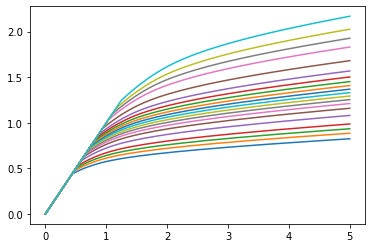

In [5]:
# Plot the consumption function at each discrete shock
m = np.linspace(PrefShockExample.solution[0].mNrmMin,5,200)
print('Consumption functions at each discrete shock:')
for j in range(PrefShockExample.PrefShkDstn[0].X.size):
    PrefShk = PrefShockExample.PrefShkDstn[0].X[j]
    c = PrefShockExample.solution[0].cFunc(m,PrefShk*np.ones_like(m))
    plt.plot(m,c)
plt.show()

Consumption function (and MPC) when shock=1:


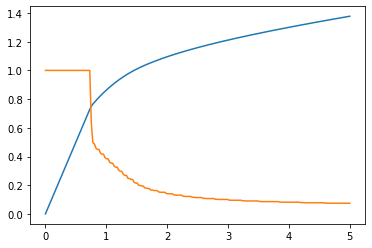

In [6]:
# Plot the consumption function and MPC when only 1 shock
print('Consumption function (and MPC) when shock=1:')
c = PrefShockExample.solution[0].cFunc(m,np.ones_like(m))
k = PrefShockExample.solution[0].cFunc.derivativeX(m,np.ones_like(m))
plt.plot(m,c)
plt.plot(m,k)
plt.show()

In [7]:
# Simulate some data
PrefShockExample.T_sim = 120
PrefShockExample.track_vars = ['cNrmNow']
PrefShockExample.makeShockHistory() # This is optional
PrefShockExample.initializeSim()
PrefShockExample.simulate()

### Utility Shocks and Different Interest Rates

In this model, an agent face idiosyncratic shocks to permanent and transitory income and multiplicative shocks to utility *and* faces a different interst rate on borrowing vs saving. This agent's model is identical to that of the $\texttt{ConsPrefShockModel}$ with the addition of the interst rate rule from the $\texttt{kinkedRConsumerType}$ from $\texttt{ConsIndShock}$ model.

The one period problem of this model is solved by the function $\texttt{solveConsKinkyPref}$, which creates an instance of $\texttt{ConsKinkyPrefSolver}$. The class $\texttt{KinkyPrefConsumerType}$ represents agents in this model. 

Thanks to HARK's object-oriented approach to solution methods, it is trivial to combine two models to make a new one. In this current case, the solver and consumer classes each inherit from both $\texttt{KinkedR}$ and $\texttt{PrefShock}$ and only need a trivial constructor function to rectify the differences between the two.



### Constructed inputs to solve KinkyPref

* The attributes required to properly construct an instance of $\texttt{KinkyPrefConsumerType}$ are the same as $\texttt{PrefShockConsumerType}$, except that $\texttt{Rfree}$ should not be replace with $\texttt{Rboro}$ and $\texttt{Rsave}$ - like the "kinked R" parent model. 

* Also, as in $\texttt{KinkedR}$ and $\texttt{PrefShock}$, $\texttt{KinkyPref}$ is not yet compatible with cubic spline interpolation of the consumption function. 

In [8]:
# This cell defines a dictionary to make an instance of a "kinky preference"  consumer, 
# who has both shocks to utility and a different interest rate on borrowing vs saving.
KinkyPrefDict={
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Default intertemporal discount factor
    "LivPrb" : [0.98],                     # Survival probability
    "AgentCount" : 10000,                  # Number of agents of this type (only matters for simulation)
    "PermGroFac" :[1.01],                  # Permanent income growth factor   

    # Parameters for constructing the "assets above minimum" grid
    "aNrmInitMean" : 0.0,                  # Mean of log initial assets (only matters for simulation)
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets (only for simulation)
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income (only matters for simulation)
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income (only matters for simulation)
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor (only matters for simulation)
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value               
    "aXtraExtra" : [None],                   # Some other value of "assets above minimum" to add to the grid
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    
    # Parameters describing the income process
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "PermShkStd" : [0.1],                  # Standard deviation of log permanent shocks to income
    "TranShkStd" : [0.1],                  # Standard deviation of log transitory shocks to income
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "UnempPrbRet" : 0.005,                 # Probability of "unemployment" while retired
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "tax_rate" : 0.0,                      # Flat income tax rate
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    
    # A few other paramaters
    "BoroCnstArt" : None,                   # kinked R is a bit silly if borrowing not allowed
    "CubicBool" : False,                   # kinked R currently only compatible with linear cFunc...
    "aXtraCount" : 48,                     # ...so need lots of extra gridpoints to make up for it
    "vFuncBool" : True,                    # Whether to calculate the value function during solution  
    
    "PrefShkCount" : 12,        # Number of points in discrete approximation to preference shock distribution
    "PrefShk_tail_N" : 4,       # Number of "tail points" on each end of pref shock dist
    "PrefShkStd" : [0.30],      # Standard deviation of utility shocks
    
    'Rboro' : 1.20,           # Interest factor on assets when borrowing, a < 0
    'Rsave' : 1.02,           # Interest factor on assets when saving, a > 0    
}
del KinkyPrefDict['Rfree'] # get rid of constant interest factor

In [9]:
# Make and solve a a "kinky preference" consumer, whose model combines KinkedR and PrefShock
KinkyPrefExample = KinkyPrefConsumerType(**KinkyPrefDict)
KinkyPrefExample.cycles = 0 # Infinite horizon
KinkyPrefExample.solve()

Consumption functions at each discrete shock:


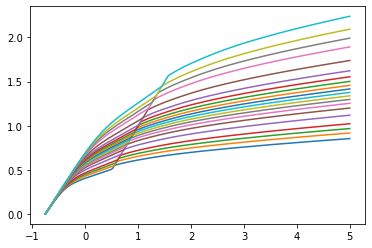

In [11]:
# Plot the consumption function at each discrete shock
m = np.linspace(KinkyPrefExample.solution[0].mNrmMin,5,200)
print('Consumption functions at each discrete shock:')
for j in range(KinkyPrefExample.PrefShkDstn[0].X.size):
    PrefShk = KinkyPrefExample.PrefShkDstn[0].X[j]
    c = KinkyPrefExample.solution[0].cFunc(m,PrefShk*np.ones_like(m))
    plt.plot(m,c)
plt.show()

Consumption function (and MPC) when shock=1:


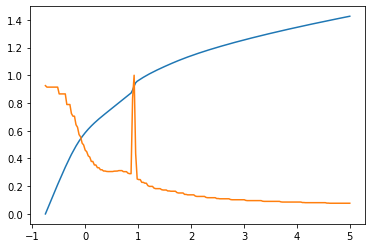

In [12]:
print('Consumption function (and MPC) when shock=1:')
c = KinkyPrefExample.solution[0].cFunc(m,np.ones_like(m))
k = KinkyPrefExample.solution[0].cFunc.derivativeX(m,np.ones_like(m))
plt.plot(m,c)
plt.plot(m,k)
plt.show()

In [13]:
# Simulate some data
KinkyPrefExample.T_sim = 120
KinkyPrefExample.track_vars = ['cNrmNow','PrefShkNow']
KinkyPrefExample.initializeSim()
KinkyPrefExample.simulate()

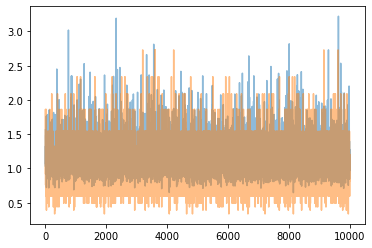

In [24]:
plt.plot(KinkyPrefExample.history['cNrmNow'][0],
         alpha = .5,
         label = 'cNrmNow')
plt.plot(KinkyPrefExample.history['PrefShkNow'][0],
         alpha = .5,
         label = 'PrefShkNow')